# Semantic modeling of blogs and analysis

In [1]:
!python -m jupyter trust *.ipynb

Signing notebook: sagemaker_local_trainer.ipynb
Signing notebook: semantic_search_modeling_analysis.ipynb


In [2]:
%load_ext autoreload
%autoreload 2

import random
import sys
import json
import pandas as pd
import numpy as np
import scipy.spatial.distance as ds
import matplotlib.pyplot as plt
import functools
import fse
import gensim
import multiprocessing
import logging

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

sys.path.append("../")

BASIC_FORMAT_LOGGING = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(format=BASIC_FORMAT_LOGGING, level=logging.INFO)

from koombea_model.config.settings import settings
from koombea_model.data_cleaning_utils import patterns_replacement, process_data

## Load Data, blogs_df, en_data, es_data

In [3]:
def load_json_file(name_file):
    with open(name_file, "r") as json_file:
        return json.load(json_file)

In [4]:
blogs_df = pd.read_csv("../data/blogs_df_{}.csv".format(settings.DB_NAME))
blogs_df["post_excerpt"].fillna("", inplace=True)
print("blogs num: {}".format(blogs_df.shape[0]))

en_data = load_json_file("../data/en_data_{}.json".format(settings.DB_NAME))
es_data = load_json_file("../data/es_data_{}.json".format(settings.DB_NAME))

blogs num: 703


In [5]:
blogs_df.head(2)

,ID,post_author,post_date,post_content,post_title,post_excerpt,post_name,post_modified,author_name,industry_id,industry_name,industry_slug,category_id,category_name,category_slug,lang,image_alt,image,post_url
0,2869,8,2021-03-22 09:00:00,"<span style=""font-weight: 400;"">Are you curiou...",Scalable Applications: Curious Why Scalability...,,why-scalability-matters-for-your-app,2021-03-22 08:56:08,Robert Kazmi,291.0,HiTech,hi-tech,6.0,Blog,blog,en,Scalable Applications: Curious Why Scalability...,https://koombea20stg.wpengine.com/wp-content/u...,https://koombea20stg.wpengine.com/blog/why-sca...
1,2873,8,2014-09-15 00:00:00,<strong>A Brief History of Scrum Agile Develop...,Is a Scrum Agile Development Process Right for...,,is-a-scrum-agile-development-process-right-for...,2014-09-15 00:00:00,Robert Kazmi,291.0,HiTech,hi-tech,6.0,Blog,blog,en,Is a Scrum Agile Development Process Right for...,https://koombea20stg.wpengine.com/wp-content/u...,https://koombea20stg.wpengine.com/blog/is-a-sc...


## Train Model

In [6]:
hyperparameters = {
    "min_count":0,
    "size":300,
    "sg":1,
    "window":15,
    "iter":40,
    "sample": 6e-5,
    "hs": 0,
    "negative": 15,
    "ns_exponent": -0.5,
    "workers": multiprocessing.cpu_count()
}

In [7]:
def train_word_vectors(data, **hyperparameters):
    _, data = zip(*data)
    model = gensim.models.Word2Vec(**hyperparameters)
    model.build_vocab(data)
    model.train(data, total_examples=model.corpus_count, epochs=model.epochs)
    return model

In [8]:
def train_blog_vectors(data, word_vector_model, **parameters):
    _, data = zip(*data)
    fse_data = fse.IndexedList(list(data))
    fse_model = fse.models.SIF(word_vector_model, **parameters)
    fse_model.train(fse_data)
    return fse_model

### English Model

In [9]:
def train_tfidf(data):
    ids_mapping, tokens_blogs = zip(*data)
    tfidf = TfidfVectorizer(tokenizer=lambda x: x.split())
    tfidf_matrix = tfidf.fit_transform(
        (" ".join(tokens_blog) for tokens_blog in tokens_blogs)
    )
    return ids_mapping, tfidf_matrix, tfidf.get_feature_names()

In [10]:
ids_en, matrix_en, vocab_en = train_tfidf(en_data)

In [11]:
wv_model_en = train_word_vectors(en_data, **hyperparameters)

2021-07-30 06:08:19,553 - INFO - collecting all words and their counts
2021-07-30 06:08:19,554 - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-30 06:08:19,613 - INFO - collected 11096 word types from a corpus of 338339 raw words and 697 sentences
2021-07-30 06:08:19,613 - INFO - Loading a fresh vocabulary
2021-07-30 06:08:19,630 - INFO - effective_min_count=0 retains 11096 unique words (100% of original 11096, drops 0)
2021-07-30 06:08:19,630 - INFO - effective_min_count=0 leaves 338339 word corpus (100% of original 338339, drops 0)
2021-07-30 06:08:19,655 - INFO - deleting the raw counts dictionary of 11096 items
2021-07-30 06:08:19,655 - INFO - sample=6e-05 downsamples 1114 most-common words
2021-07-30 06:08:19,656 - INFO - downsampling leaves estimated 154779 word corpus (45.7% of prior 338339)
2021-07-30 06:08:19,680 - INFO - estimated required memory for 11096 words and 300 dimensions: 32178400 bytes
2021-07-30 06:08:19,680 - INFO - resetting lay

In [12]:
bv_model_en = train_blog_vectors(en_data, wv_model_en, components = 0,
                                 workers = hyperparameters["workers"], lang_freq = "en")

/opt/conda/envs/python38/lib/python3.8/site-packages/fse/models/base_s2v.py:114: UserWarning: C extension not loaded, training/inferring will be slow. Install a C compiler and reinstall fse.
  warnings.warn(
2021-07-30 06:10:36,386 - INFO - no frequency mode: using wordfreq for estimation of frequency for language: en
2021-07-30 06:10:36,675 - INFO - scanning all indexed sentences and their word counts
2021-07-30 06:10:36,677 - INFO - finished scanning 697 sentences with an average length of 485 and 338339 total words
2021-07-30 06:10:36,681 - INFO - estimated memory for 697 sentences with 300 dimensions and 11096 vocabulary: 13 MB (0 GB)
2021-07-30 06:10:36,681 - INFO - initializing sentence vectors for 697 sentences
2021-07-30 06:10:36,685 - INFO - pre-computing SIF weights for 11096 words
2021-07-30 06:10:36,691 - INFO - begin training
2021-07-30 06:10:36,948 - INFO - worker thread finished; awaiting finish of 3 more threads
2021-07-30 06:10:36,960 - INFO - worker thread finished; a

#### Show some results

In [13]:
def show_word_similarity_table(word_vector_model, *words, top_n = 10):
    index = [word for word in words if word in word_vector_model.wv]
    get_topn_words = lambda word, top_n: list(zip(*word_vector_model.wv.most_similar(word, topn = top_n)))[0]
    data = [get_topn_words(word, top_n) for word in index if word in word_vector_model.wv]
    return pd.DataFrame(index = index, data = data, columns = ["top_{}".format(i + 1) for i in range(top_n)])

In [14]:
def show_query_similarity_table(blogs_df, query, ids_mapping, blog_vector_model, lang = "en", top_n = 10):
    query = process_data(query, lang, lemmatize=True, remove_stops=True, patterns_replacement=patterns_replacement)
    query_vector = blog_vector_model.infer([(query, 0)])
    similarity_results = ds.cdist(query_vector, blog_vector_model.sv.vectors, metric="cosine").squeeze()
    idx_sorted = similarity_results.argsort()
    results = [
        [
            blogs_df[blogs_df["ID"] == ids_mapping[idx]]["post_title"].item(),
            1 - value,
        ]
        for idx, value in zip(idx_sorted, similarity_results[idx_sorted])
    ][:top_n]
    index = [
        ids_mapping[idx]
        for idx, _ in zip(idx_sorted, similarity_results[idx_sorted])
    ][:top_n]
    return pd.DataFrame(
        index=index, data=results, columns=["post_title", "similarity_value"]
    )

In [15]:
def show_blogs_similarity_table(blog_id, ids_mapping, blog_vector_model, top_n = 10):
    ids2idx = {ids: idx for idx, ids in enumerate(ids_mapping)}
    similarity_results = blog_vector_model.sv.most_similar(ids2idx[blog_id], topn=top_n)
    results = [
        [blogs_df[blogs_df["ID"] == ids_mapping[idx]]["post_title"].item(), value]
        for idx, value in similarity_results
    ]
    return pd.DataFrame(
        index=[ids_mapping[idx] for idx, _ in similarity_results[:top_n]],
        data=results,
        columns=["post_title", "similarity_value"],
    )   

In [16]:
show_word_similarity_table(wv_model_en, "python", "jonathan", "devop", "koombea", top_n = 5)

2021-07-30 06:10:37,343 - INFO - precomputing L2-norms of word weight vectors


,top_1,top_2,top_3,top_4,top_5
python,sweigart,scraping,academia,broader,compilation
jonathan,tarud,warner,aportar,posición,encargado
devop,staging,digitalocean,linode,op,troubleshooter
koombea,sldc,headquarters,rhomobile,lunas,uncease


In [17]:
show_query_similarity_table(blogs_df, "what is machine learning?", ids_en, bv_model_en, lang="en", top_n = 10)

2021-07-30 06:10:37,731 - INFO - scanning all indexed sentences and their word counts
2021-07-30 06:10:37,733 - INFO - finished scanning 1 sentences with an average length of 2 and 2 total words
2021-07-30 06:10:37,736 - INFO - no removal of principal components


,post_title,similarity_value
5263,Deep Learning vs Machine Learning,0.797855
5415,Machine Learning Frameworks,0.752507
4565,Understanding Machine Learning,0.747288
4481,5 Uses of Machine Learning for Web and Mobile ...,0.717016
5134,Deep Learning Applications for FinTech,0.696794
4231,7 Different Types of Artificial Intelligence,0.692174
4519,The Differences Between Artificial Intelligenc...,0.685285
5036,Advances in Financial Machine Learning,0.676275
3671,How HiTech Organizations Can Use AI and Machin...,0.667314
3759,Artificial Intelligence: Where is the Intersec...,0.658648


In [18]:
show_blogs_similarity_table(5263, ids_en, bv_model_en)

2021-07-30 06:10:38,273 - INFO - precomputing L2-norms of sentence vectors


,post_title,similarity_value
4565,Understanding Machine Learning,0.971242
5134,Deep Learning Applications for FinTech,0.966264
5415,Machine Learning Frameworks,0.965316
4481,5 Uses of Machine Learning for Web and Mobile ...,0.951059
4519,The Differences Between Artificial Intelligenc...,0.937221
5036,Advances in Financial Machine Learning,0.935685
4231,7 Different Types of Artificial Intelligence,0.926218
5265,How to Create an AI Powered App,0.922959
3392,4 Examples of How AI Is Used by Mobile Apps,0.922926
4571,8 Uses of AI and Machine Learning in FinTech,0.916970


#### Validate Model

To validate model we are going to calculate the accuracy results for searching using top accuracy metrics for top 3, top 5, and top 10.

In [19]:
def quiete_logs(target="fse"):
    for name in logging.root.manager.loggerDict:
        if "fse" in name:
            logging.getLogger(name=name).setLevel(logging.WARN)
quiete_logs()

In [20]:
from tqdm.auto import tqdm

def cache_results(blogs_df, ids_mapping, blog_vector_model, lang = "en", max_top = 100):
    blogs_df_temp = blogs_df[blogs_df["lang"] == lang]
    return [
            (
                row.ID,
                show_query_similarity_table(
                    blogs_df_temp, row.post_title, ids_mapping, blog_vector_model, top_n=max_top
                ).index,
            )
            for row in tqdm(
                blogs_df_temp.itertuples(),
                total=blogs_df_temp.shape[0],
                desc=f"Extracting {max_top} predictions",
            )
        ]

cache_results_en = cache_results(blogs_df, ids_en, bv_model_en)

Extracting 100 predictions:   0%|          | 0/697 [00:00<?, ?it/s]

In [21]:
from enum import Enum

class Top(int, Enum):
    top3 = 3
    top5 = 5
    top10 = 10
    top15 = 15
    
def compute_accuracy(targets, cache_results):
    if isinstance(targets, Top):
        targets = [targets]
    accuracies_top = [
        [(target.name, id_target in ids_result[:target]) for target in targets]
        for id_target, ids_result in cache_results
    ]
    accuracies_top = {
        acc_list[0][0]: functools.reduce(lambda x, y: x + int(y[1]), acc_list, 0)
        / len(acc_list)
        for acc_list in zip(*accuracies_top)
    }
    return accuracies_top

def calculate_distance(cache_results, targets, top_distance_bad_good = 5, n_top = 5):
    distances_per_target = [
        [
            (
                target.name,
                id_target,
                ids_result[:n_top].tolist(),
                target - ids_result.get_indexer_for([id_target]).item(),
            )
            for target in targets
        ]
        for id_target, ids_result in cache_results
    ]

    def calculate_bads_goods(acc_list, top_distance_bad_good: int):
        acc_list = sorted(acc_list, key=lambda x: x[-1])
        return [
            (acc_list[i][1:], acc_list[-i - 1][1:])
            for i in range(top_distance_bad_good)
        ]

    distances_top = {
        acc_list[0][0]: calculate_bads_goods(acc_list, top_distance_bad_good)
        for acc_list in zip(*distances_per_target)
    }
    return distances_top

def describe_model(blogs_df, blog_model_vector, cache_results, targets,
                   top_distance_bad_good = 10, n_top = 5, lang = "en"):
    # blogs
    blogs_df = blogs_df[blogs_df["lang"] == lang]
    # get accuracy for each top
    accuracies_top = compute_accuracy(targets, cache_results)
    # get top blogs with highest distance bad and good this is only necessary for only one top
    distances_top = calculate_distance(
        cache_results,
        targets=[max(targets)],
        top_distance_bad_good=top_distance_bad_good,
        n_top=n_top,
    )
    # calculate distance and make a summary table
    distances_data = [
        (
            result_type + "_result",
            blog_id,
            blogs_df[blogs_df["ID"] == blog_id].post_title.item(),
            metric_val,
            *[
                blogs_df[blogs_df["ID"] == best_id].post_title.item()
                for best_id in best_results
            ],
        )
        for _, values_type in distances_top.items()
        for result_type, values in zip(["bad", "good"], zip(*values_type))
        for blog_id, best_results, metric_val in values
    ]
    distances_columns = [
        "top_type",
        "expected_id",
        "expected_blog_slug",
        "result_metric",
        *[f"top_{i + 1}" for i in range(n_top)],
    ]
    return (
        pd.DataFrame(data=distances_data, columns=distances_columns),
        pd.DataFrame(
            data=[val for val in accuracies_top.values()],
            index=[key for key in accuracies_top.keys()],
            columns=["accuracy_results"],
        ),
    )

With the previous functions we can validate the search system and see what are the best and the worst results using the model. This summary is put in an organized way in tables using pandas dataframes.

In [22]:
summary_df_en, accuracies_df_en =  describe_model(
    blogs_df, bv_model_en, 
    cache_results_en,
    targets = [Top.top3, Top.top5, Top.top10, Top.top15],
    top_distance_bad_good=3
)

##### Summary tables

In [23]:
summary_df_en

,top_type,expected_id,expected_blog_slug,result_metric,top_1,top_2,top_3,top_4,top_5
0,bad_result,4178,5 Enterprise FinTech Apps to Learn From,-54,Enterprise Mobile Application Development Stra...,Starting a FinTech Company: What Every FinTech...,What Is FinTech?,5 Things to Consider Before Launching Your Fin...,Best Practices for Developing a FinTech App
1,bad_result,3305,7 Trends in Mobile UX,-42,Why Bad UX Is More Expensive Than Good UX,UX Trends: A Complete Guide to Understanding Y...,What Do Best Practices in App UX Look Like?,What a Mobile App Can Do for Your Retail Busin...,Intelligent App Design: Tips for Creating Apps...
2,bad_result,3516,The Evolution of Front-End Development at Koombea,-39,Koombea in 2018: A Year in Review,Why Choose Koombea as Your App Development Par...,Celebrating Koombea’s Inclusion in Clutch’s Li...,Koombea Named a Top Mobile App Development Com...,Trouble Finding The Right App Development Part...
3,good_result,6094,Ruby on Rails Vs. Django,15,Ruby on Rails Vs. Django,Ruby Vs Ruby on Rails: What’s the Difference?,Ruby on Rails Vs. Node.js Explained,Ruby on Rails Routes Explained,What is Ruby on Rails Used For?
4,good_result,6084,Koombea’s Employees Receive COVID-19 Vaccines,15,Koombea’s Employees Receive COVID-19 Vaccines,Are Diagnostic Testing Apps the Future of MedT...,Koombea Recognizes Our Team’s Efforts Througho...,9 Years and Counting: Koombea's Anniversary,Koombea in 2018: A Year in Review
5,good_result,6080,What is Laravel?,15,What is Laravel?,Ruby on Rails Vs. Django,Ruby on Rails Vs. Node.js Explained,A Guide to Web Development Frameworks in 2021,Angular Vs. React: What’s The Difference?


In [24]:
accuracies_df_en

,accuracy_results
top3,0.863702
top5,0.916786
top10,0.964132
top15,0.977044


#### Visualization of results, embeddings and bar accuracy metrics of each top

In [25]:
#@functools.lru_cache
def train_mapping_reduction_cluster(blogs_vectors, n_clusters: int):
    blogs_vectors = np.array(blogs_vectors)
    tsne = TSNE(n_components=2).fit_transform(blogs_vectors)
    c = KMeans(n_clusters=n_clusters).fit_predict(blogs_vectors)
    return tsne, c


def get_random_stratify(clusters: np.ndarray, total_points: int, n_clusters: int):
    if total_points > 15:
        partitions = (
            total_points // n_clusters
            if not total_points % n_clusters
            else total_points // n_clusters + 1
        )
    else:
        partitions = len(clusters)
    # get groups
    groups = {i: [] for i in np.unique(clusters)}
    for idx, val in enumerate(clusters):
        groups[val].append(idx)
    # return indexes selected randomly in each partition
    return functools.reduce(
        lambda x, y: x + random.choices(y[1], k=partitions), groups.items(), []
    )

In [26]:
def plot_blogs_embeddings(blog_vector_model, tfidf_matrix, vocab, n_clusters = 20, total_points = 100, ntop = 3, **kwargs):
    title = kwargs.get("plot_title")
    fontsize = kwargs.get("fontsize", 20)
    if n_clusters > tfidf_matrix.shape[0]: n_clusters = tfidf_matrix.shape[0] // 2
    if "fontsize" in kwargs: del kwargs["fontsize"]
    if "plot_title" in kwargs:  del kwargs["plot_title"]
    fig, ax = plt.subplots(1, 1, **kwargs)
    # train clusters and tsne
    vectors_hashable = tuple(tuple(row) for row in blog_vector_model.sv.vectors.tolist())
    tsne, c = train_mapping_reduction_cluster(vectors_hashable, n_clusters)
    # select random indexed stratify
    idx_blogs = get_random_stratify(c, total_points, n_clusters)
    # make configuration to plot
    matrix_top_n = tfidf_matrix.toarray().argsort(axis=1)[idx_blogs, -ntop:]
    # get words
    words = [list(np.array(vocab)[i]) for i in matrix_top_n]
    # plot points
    ax.scatter(tsne[idx_blogs, 0], tsne[idx_blogs, 1], c = c[idx_blogs], s = 50)
    # annotate
    for i, word in zip(idx_blogs, words):
        ax.annotate(" ".join(word), xy=(tsne[i, 0], tsne[i, 1]), fontsize=fontsize)
    ax.set_title(title)
    plt.show()

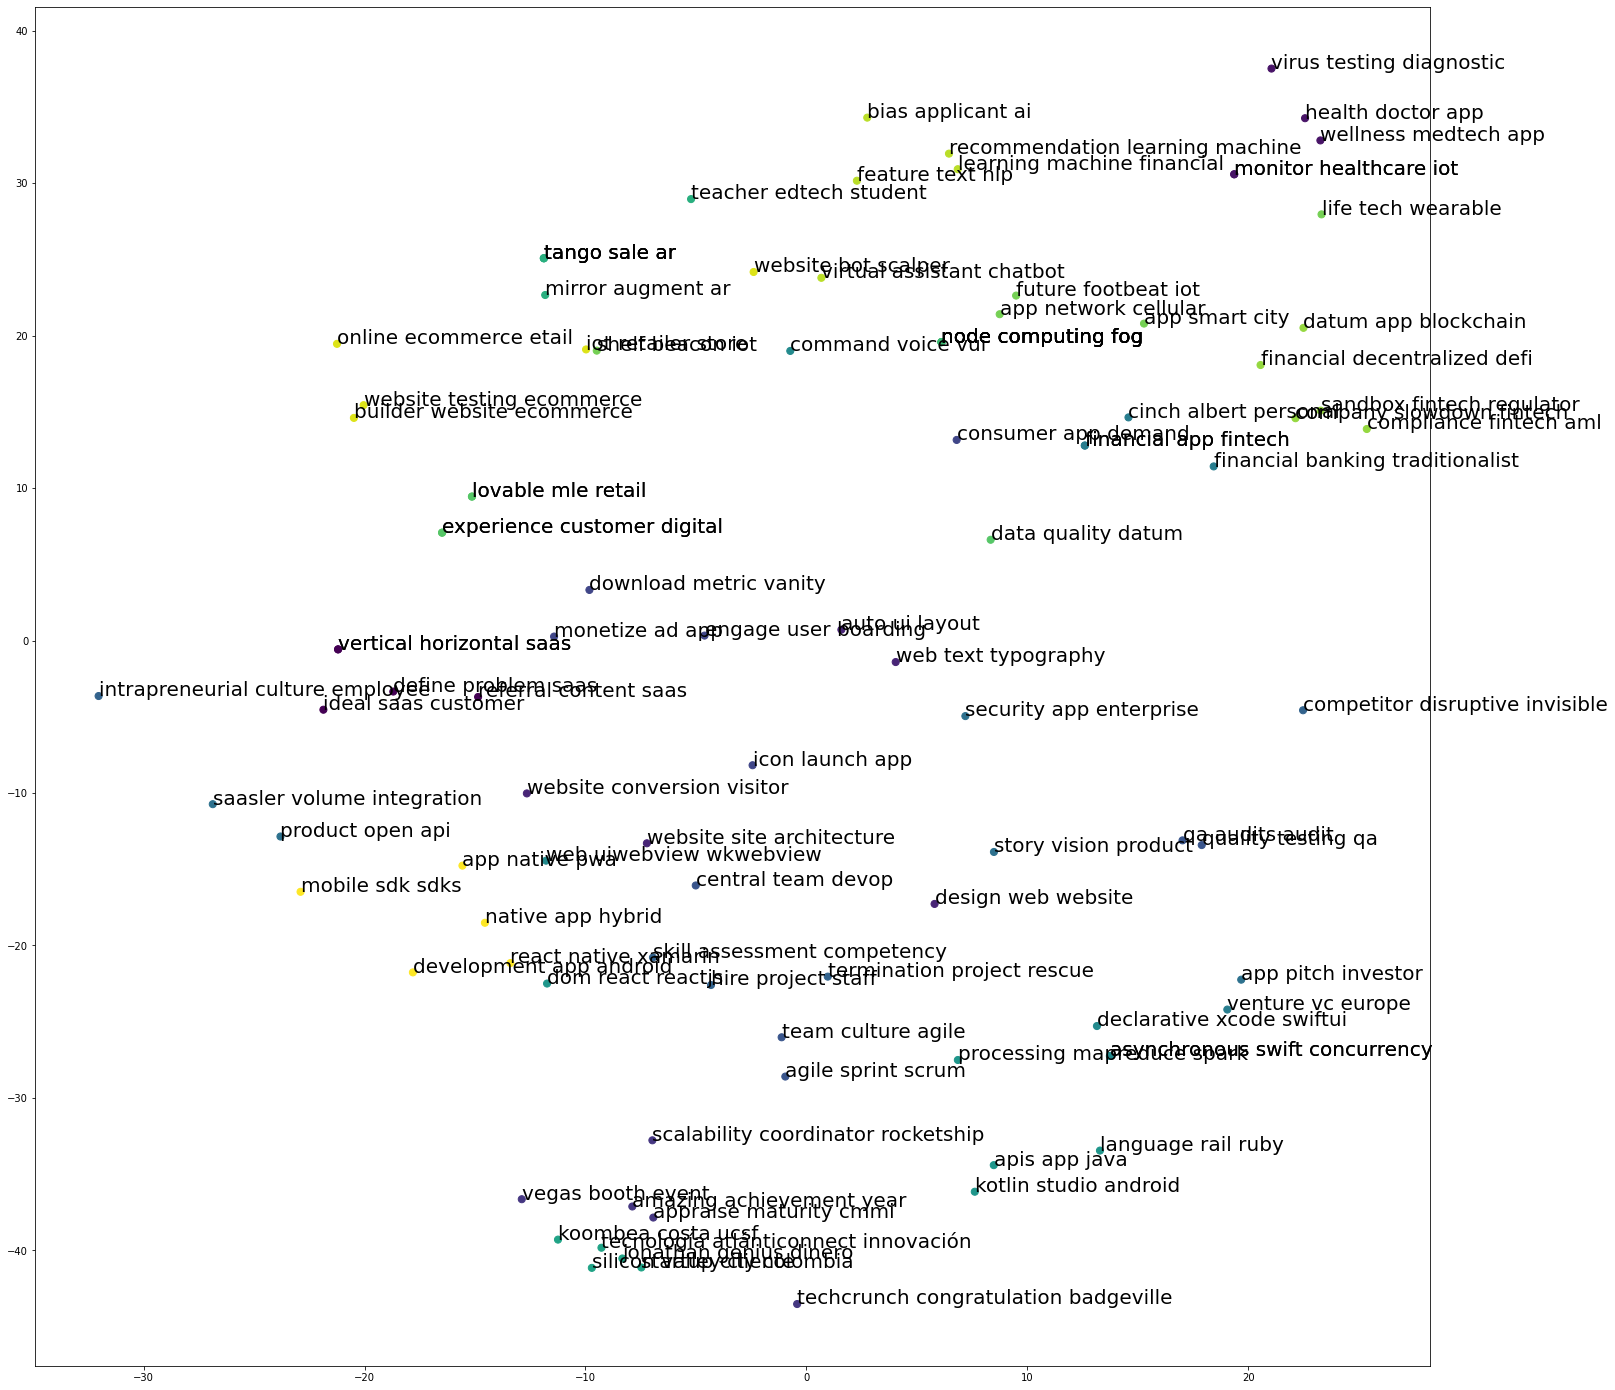

In [27]:
plot_blogs_embeddings(bv_model_en, matrix_en, vocab_en, figsize=(25, 25))

In [28]:
def plot_accuracies(accuracies_df, **kwargs):
    kwargs["xlabel"] = kwargs.get("xlabel") or "tops"
    kwargs["ylabel"] = kwargs.get("ylabel") or "accuracy results"
    ax = accuracies_df.plot.bar(y = "accuracy_results", **kwargs)
    plt.show()

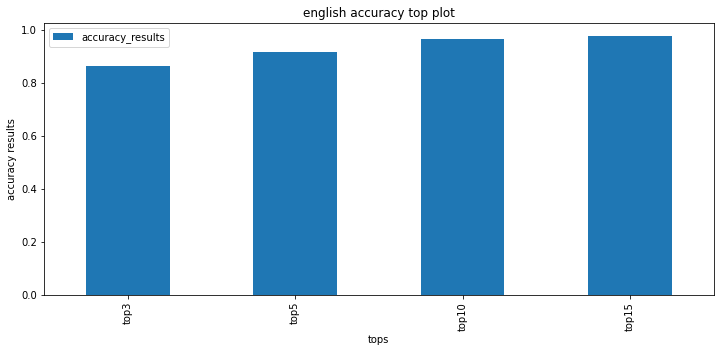

In [29]:
plot_accuracies(accuracies_df_en, title = "english accuracy top plot", figsize = (12, 5))

### Spanish Model

In [30]:
ids_es, matrix_es, vocab_es = train_tfidf(es_data)

In [31]:
wv_model_es = train_word_vectors(es_data, **hyperparameters)

2021-07-30 06:14:19,778 - INFO - collecting all words and their counts
2021-07-30 06:14:19,781 - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-30 06:14:19,784 - INFO - collected 882 word types from a corpus of 2441 raw words and 6 sentences
2021-07-30 06:14:19,788 - INFO - Loading a fresh vocabulary
2021-07-30 06:14:19,795 - INFO - effective_min_count=0 retains 882 unique words (100% of original 882, drops 0)
2021-07-30 06:14:19,796 - INFO - effective_min_count=0 leaves 2441 word corpus (100% of original 2441, drops 0)
2021-07-30 06:14:19,804 - INFO - deleting the raw counts dictionary of 882 items
2021-07-30 06:14:19,806 - INFO - sample=6e-05 downsamples 882 most-common words
2021-07-30 06:14:19,807 - INFO - downsampling leaves estimated 620 word corpus (25.4% of prior 2441)
2021-07-30 06:14:19,809 - INFO - estimated required memory for 882 words and 300 dimensions: 2557800 bytes
2021-07-30 06:14:19,810 - INFO - resetting layer weights
2021-07-30 06:

In [32]:
bv_model_es = train_blog_vectors(es_data, wv_model_es, components = 0,
                                 workers=hyperparameters["workers"], lang_freq = "es")

/opt/conda/envs/python38/lib/python3.8/site-packages/fse/models/base_s2v.py:114: UserWarning: C extension not loaded, training/inferring will be slow. Install a C compiler and reinstall fse.
  warnings.warn(


#### Show some results

In [33]:
show_word_similarity_table(bv_model_es, "shopify", "magento", "crisis", top_n=5)

2021-07-30 06:14:21,790 - INFO - precomputing L2-norms of word weight vectors


,top_1,top_2,top_3,top_4,top_5
shopify,plataforma,transacción,ofrecer,pago,alternativa
magento,plantilla,código,malo,plugins,usd
crisis,navegar,entregamos,turbulento,sobresaliente,coincidencia


In [34]:
show_query_similarity_table(blogs_df, "como navegar la crisis con shopify", ids_es, bv_model_es, lang = "es", top_n = 10)

,post_title,similarity_value
4590,Tu Tienda Online Necesita un Aliado Shopify Plus,0.999890
4589,Magento o Shopify - ¿Cuál escoger para mi tien...,0.999890
4588,Cómo Usar Shopify Para Navegar la Crisis,0.999889
5658,Un aliado Shopify: Colombia,0.999871
4768,"Colombia, Mucho por Aprender Aun en Temas de e...",0.999707
4770,Cómo Escoger Un Aliado Tecnológico,0.999614


In [35]:
show_blogs_similarity_table(4589, ids_es, bv_model_es)

,post_title,similarity_value
4588,Cómo Usar Shopify Para Navegar la Crisis,0.999925
4590,Tu Tienda Online Necesita un Aliado Shopify Plus,0.999922
5658,Un aliado Shopify: Colombia,0.999886
4768,"Colombia, Mucho por Aprender Aun en Temas de e...",0.999788
4770,Cómo Escoger Un Aliado Tecnológico,0.999712


#### Validate the model
This part for the spanish blogs is not really necessary, because there are not a lot of blogs in the spanish section, just 5 or 6.

In [36]:
cache_results_es = cache_results(blogs_df, ids_es, bv_model_es, lang = "es")

Extracting 100 predictions:   0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
summary_df_es, accuracies_df_es =  describe_model(
    blogs_df, bv_model_es, 
    cache_results_es,
    targets = [Top.top3, Top.top5, Top.top10, Top.top15],
    top_distance_bad_good=3, lang = "es"
)

In [38]:
summary_df_es

,top_type,expected_id,expected_blog_slug,result_metric,top_1,top_2,top_3,top_4,top_5
0,bad_result,4588,Cómo Usar Shopify Para Navegar la Crisis,13,Tu Tienda Online Necesita un Aliado Shopify Plus,Magento o Shopify - ¿Cuál escoger para mi tien...,Cómo Usar Shopify Para Navegar la Crisis,Un aliado Shopify: Colombia,"Colombia, Mucho por Aprender Aun en Temas de e..."
1,bad_result,4770,Cómo Escoger Un Aliado Tecnológico,13,"Colombia, Mucho por Aprender Aun en Temas de e...",Tu Tienda Online Necesita un Aliado Shopify Plus,Cómo Escoger Un Aliado Tecnológico,Un aliado Shopify: Colombia,Cómo Usar Shopify Para Navegar la Crisis
2,bad_result,4589,Magento o Shopify - ¿Cuál escoger para mi tien...,15,Magento o Shopify - ¿Cuál escoger para mi tien...,Tu Tienda Online Necesita un Aliado Shopify Plus,Cómo Usar Shopify Para Navegar la Crisis,Un aliado Shopify: Colombia,"Colombia, Mucho por Aprender Aun en Temas de e..."
3,good_result,5658,Un aliado Shopify: Colombia,15,Un aliado Shopify: Colombia,Tu Tienda Online Necesita un Aliado Shopify Plus,Cómo Usar Shopify Para Navegar la Crisis,Magento o Shopify - ¿Cuál escoger para mi tien...,"Colombia, Mucho por Aprender Aun en Temas de e..."
4,good_result,4768,"Colombia, Mucho por Aprender Aun en Temas de e...",15,"Colombia, Mucho por Aprender Aun en Temas de e...",Un aliado Shopify: Colombia,Tu Tienda Online Necesita un Aliado Shopify Plus,Cómo Usar Shopify Para Navegar la Crisis,Magento o Shopify - ¿Cuál escoger para mi tien...
5,good_result,4590,Tu Tienda Online Necesita un Aliado Shopify Plus,15,Tu Tienda Online Necesita un Aliado Shopify Plus,Un aliado Shopify: Colombia,Cómo Usar Shopify Para Navegar la Crisis,Magento o Shopify - ¿Cuál escoger para mi tien...,"Colombia, Mucho por Aprender Aun en Temas de e..."


In [39]:
accuracies_df_es

,accuracy_results
top3,1.0
top5,1.0
top10,1.0
top15,1.0


#### Visualization of results, embeddings and bar accuracy metrics of each top

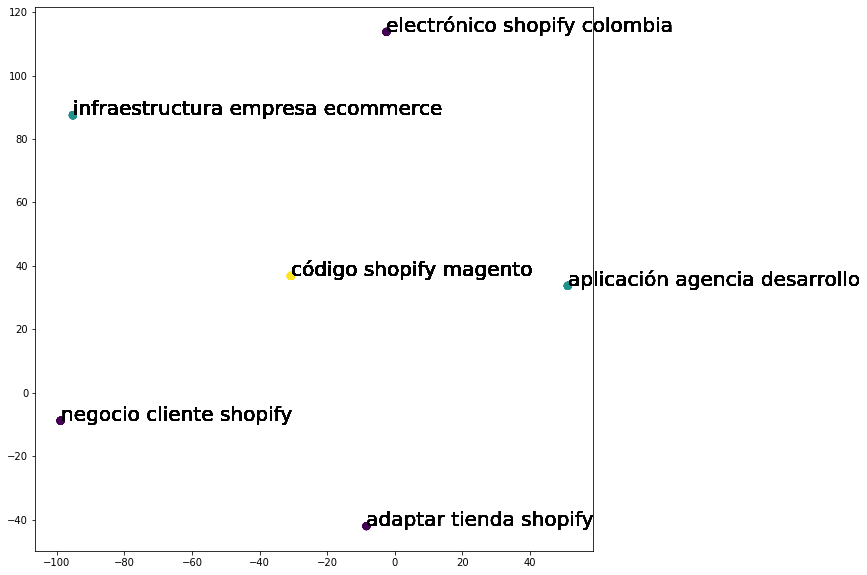

In [40]:
plot_blogs_embeddings(bv_model_es, matrix_es, vocab_es, figsize=(10, 10), fontsize=20)

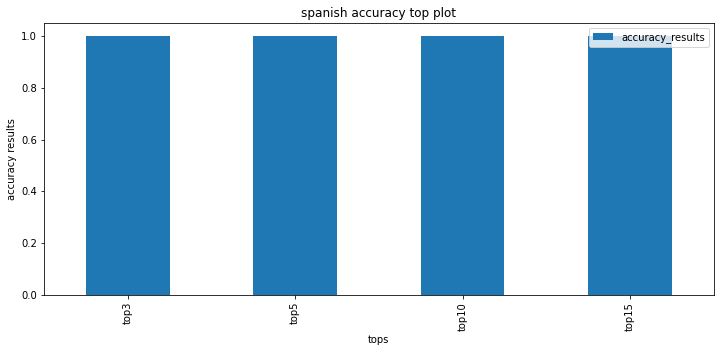

In [41]:
plot_accuracies(accuracies_df_es, title = "spanish accuracy top plot", figsize = (12, 5))

# Save models

In [42]:
# save models
bv_model_en.save("../models/bv_model_en_{}.bv".format(settings.DB_NAME))
bv_model_es.save("../models/bv_model_es_{}.bv".format(settings.DB_NAME))

2021-07-30 06:14:23,963 - INFO - saving SIF object under ../models/bv_model_en_wp_koombea20stg.bv, separately None
2021-07-30 06:14:24,564 - INFO - saved ../models/bv_model_en_wp_koombea20stg.bv
2021-07-30 06:14:24,567 - INFO - saving SIF object under ../models/bv_model_es_wp_koombea20stg.bv, separately None
2021-07-30 06:14:24,614 - INFO - saved ../models/bv_model_es_wp_koombea20stg.bv


In [43]:
# save mappings
ids_en_name = "../models/idx2ids_mapping_en_{}.json".format(settings.DB_NAME)
ids_es_name = "../models/idx2ids_mapping_es_{}.json".format(settings.DB_NAME)
with open(ids_en_name, "w") as ids_en_file, open(ids_es_name, "w") as ids_es_file:
    json.dump(ids_en, ids_en_file)
    json.dump(ids_es, ids_es_file)

In [44]:
blogs_df_name = "../models/blogs_df_{}.csv".format(settings.DB_NAME)
blogs_df.to_csv(blogs_df_name, index=False)